<a href="https://colab.research.google.com/github/Jyuuni12/GEOG5990M_project_assignmnt/blob/main/GEOG5990M_Final_Project_201783946.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GEOG5990M Final Assignment

Student ID number:201783946

In [102]:
# read in required packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import os
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import numpy as np
!pip install mapclassify --upgrade

Ensure all files are completely uploaded, and proceed to load the required datasets: Priority Places for Food Index data (`ppfi_index_v2_nov2023.csv`)<a href="#ref1">[1]</a>, Output Area Classification data (`oac21ew.csv`)<a href="#ref1">[2]</a>, Postcode to OA (2021) to LSOA to MSOA to LAD with Classifications (November 2023) Best Fit Lookup in the UK (`NSP21CL_NOV23_UK_LU_1.csv`)<a href="#ref1">[3]</a>, and the classification_codes_and_names file<a href="#ref1">[2]</a>.



In [103]:
# Load csv file
UK_data = pd.read_csv('/content/NSP21CL_NOV23_UK_LU_1.csv', encoding='latin1')
ppfi_data = pd.read_csv('/content/ppfi_index_v2_nov2023.csv')
oac_data = pd.read_csv('/content/oac21ew.csv')
classification_data = pd.read_csv('/content/classification_codes_and_names.csv')

# Unzip shapefile data
with ZipFile('/content/OAC_shapefile.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/shapefiles')

# Load shapefile data
shapefile_path = '/content/shapefiles/' + [f for f in os.listdir('/content/shapefiles') if f.endswith('.shp')][0]
oac_shapefile = gpd.read_file(shapefile_path)

<ipython-input-103-d98f1c05d7f0>:2: DtypeWarning: Columns (15,17,18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  UK_data = pd.read_csv('/content/NSP21CL_NOV23_UK_LU_1.csv', encoding='latin1')


In [104]:
# View data information
ppfi_data.info()
oac_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43538 entries, 0 to 43537
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   lsoa21cd                                 43538 non-null  object 
 1   domain_supermarket_proximity             43538 non-null  int64  
 2   domain_supermarket_accessibility         42648 non-null  float64
 3   domain_ecommerce_access                  42648 non-null  float64
 4   domain_socio_demographic                 43538 non-null  int64  
 5   domain_nonsupermarket_proximity          43538 non-null  int64  
 6   domain_food_for_families                 43538 non-null  int64  
 7   domain_fuel_poverty                      42648 non-null  float64
 8   country                                  43538 non-null  object 
 9   country_denominator                      43538 non-null  int64  
 10  combined                                 43538

It has been observed that there is no common field between the Priority Places for Food Index data and the Output Area Classification data. Therefore, it is necessary to use the "Postcode to OA (2021) to LSOA to MSOA to LAD with Classifications (November 2023) Best Fit Lookup in the UK" file to link these two datasets. However, given the considerable size of this file, it is prudent to first filter out only the data relevant to the Leeds area before proceeding with further data processing.

In [105]:
# Extract data of Leeds
leeds_data = UK_data[UK_data['ladnm'] == 'Leeds']

print(leeds_data.head()) # View the first few lines of the extraction result

           pcd7      pcd8      pcds  dointr    doterm  usertype  oseast1m  \
152702  BD1 1JS  BD1  1JS   BD1 1JS  198001  198612.0         0  421900.0   
154271  BD100FE  BD10 0FE  BD10 0FE  201509       NaN         0  419653.0   
154349  BD100NJ  BD10 0NJ  BD10 0NJ  198001       NaN         0  419835.0   
154350  BD100NL  BD10 0NL  BD10 0NL  198001       NaN         0  419685.0   
154354  BD100NR  BD10 0NR  BD10 0NR  199208       NaN         1  419927.0   

        osnrth1m     oa21cd oac11cd  ...    lsoa21nm   msoa21cd   msoa21nm  \
152702  428500.0  E00058072     5A1  ...  Leeds 096D  E02002425  Leeds 096   
154271  437767.0  E00058441     5B3  ...  Leeds 039B  E02002368  Leeds 039   
154349  437762.0  E00058441     5B3  ...  Leeds 039B  E02002368  Leeds 039   
154350  437725.0  E00058441     5B3  ...  Leeds 039B  E02002368  Leeds 039   
154354  438253.0  E00057706     5B2  ...  Leeds 027C  E02002356  Leeds 027   

       soac11cd                        soac11nm      ladcd  ladnm la

Before proceeding with the merge, it is essential to ensure that the data types of the columns to be merged are the same. Therefore, one should first examine the data types of all the columns involved in the merge. If there are differing types, a conversion is necessary before the merge can take place.

In [106]:
# Print the data types of the relevant columns that need to be merged in the data
print(leeds_data['lsoa21cd'].dtype)
print(leeds_data['oa21cd'].dtype)
print(ppfi_data['lsoa21cd'].dtype)
print(oac_data['oa21cd'].dtype)
print(oac_data['supergroup'].dtype)
print(classification_data['Classification Code'].dtype)

object
object
object
object
int64
object


At this point, it is observed that the data type of the 'supergroup' column differs from the others. Therefore, prior to merging, it is necessary to convert the 'supergroup' from its current int64 data type to an object type, and verify that the conversion has been correctly executed.

In [107]:
# Convert the 'supergroup' column from int64 to object type
oac_data['supergroup'] = oac_data['supergroup'].astype(str)

# Print the data type of the converted column to confirm successful conversion
print(oac_data['supergroup'].dtype)

object


After successfully converting the 'supergroup' data type to object, proceed by merging the data based on geographic codes. Subsequently, review the information contained within the merged data to see what insights can be gleaned.

In [108]:
# Merge data based on geographic codes
merged_data = pd.merge(leeds_data, ppfi_data, on='lsoa21cd', how='inner')
merged_data = pd.merge(merged_data, oac_data[['oa21cd', 'supergroup']], on='oa21cd', how='inner')
leeds_specific = pd.merge(merged_data, classification_data, left_on='supergroup', right_on='Classification Code', how='inner')

# View data information
leeds_specific.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30525 entries, 0 to 30524
Data columns (total 49 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   pcd7                                     30525 non-null  object 
 1   pcd8                                     30525 non-null  object 
 2   pcds                                     30525 non-null  object 
 3   dointr                                   30525 non-null  int64  
 4   doterm                                   9883 non-null   float64
 5   usertype                                 30525 non-null  int64  
 6   oseast1m                                 30525 non-null  float64
 7   osnrth1m                                 30525 non-null  float64
 8   oa21cd                                   30525 non-null  object 
 9   oac11cd                                  30525 non-null  object 
 10  oac11nm                                  30525

Following the merge, which resulted in a dataset comprising 49 columns, it is practical to extract only those columns relevant for analysis to enhance clarity and computational efficiency. The remaining superfluous columns should be discarded. Subsequently, inspect the extracted data for any missing values and review the final dataset information to ensure there are no errors in the extraction process.

In [109]:
# Reserve the required columns
columns_needed = ['lsoa21cd', 'oa21cd', 'domain_ecommerce_access', 'Classification Name', 'ladnm']
leeds_specific = leeds_specific[columns_needed]

# Check for missing data
print(leeds_specific.isnull().sum())

lsoa21cd                   0
oa21cd                     0
domain_ecommerce_access    0
Classification Name        0
ladnm                      0
dtype: int64


In [110]:
# View result data
print(leeds_specific.head())

    lsoa21cd     oa21cd  domain_ecommerce_access  \
0  E01011527  E00058072                  17166.0   
1  E01011527  E00058072                  17166.0   
2  E01011527  E00058072                  17166.0   
3  E01011527  E00058072                  17166.0   
4  E01011527  E00058072                  17166.0   

               Classification Name  ladnm  
0  Suburbanites and Peri-Urbanites  Leeds  
1  Suburbanites and Peri-Urbanites  Leeds  
2  Suburbanites and Peri-Urbanites  Leeds  
3  Suburbanites and Peri-Urbanites  Leeds  
4  Suburbanites and Peri-Urbanites  Leeds  


Data Visualisation


---


non-spatial data visualisation: A bar chart consists of several bar graphs, each representing a comparison among different data categories. The data is shown as parallel rectangular bars that vary in length but have the same width. Each bar corresponds to particular data, with its length determined by the data values it represents. The bars are discrete and do not touch each other<a href="#ref1">[4]</a>.To illustrate the differences in E-commerce Access across various Output Area Classifications in the Leeds area, a bar chart was selected. Given the lengthy names of the classifications in the Output Area Classification, the horizontal axis labels were rotated by 45 degrees to prevent overlap. To facilitate the comparison of specific values, the interval of the vertical axis was adjusted to 2000, and grid lines were added to aid in reading the values. Additionally, to accommodate colour-blind users, the coolwarm palette was employed.

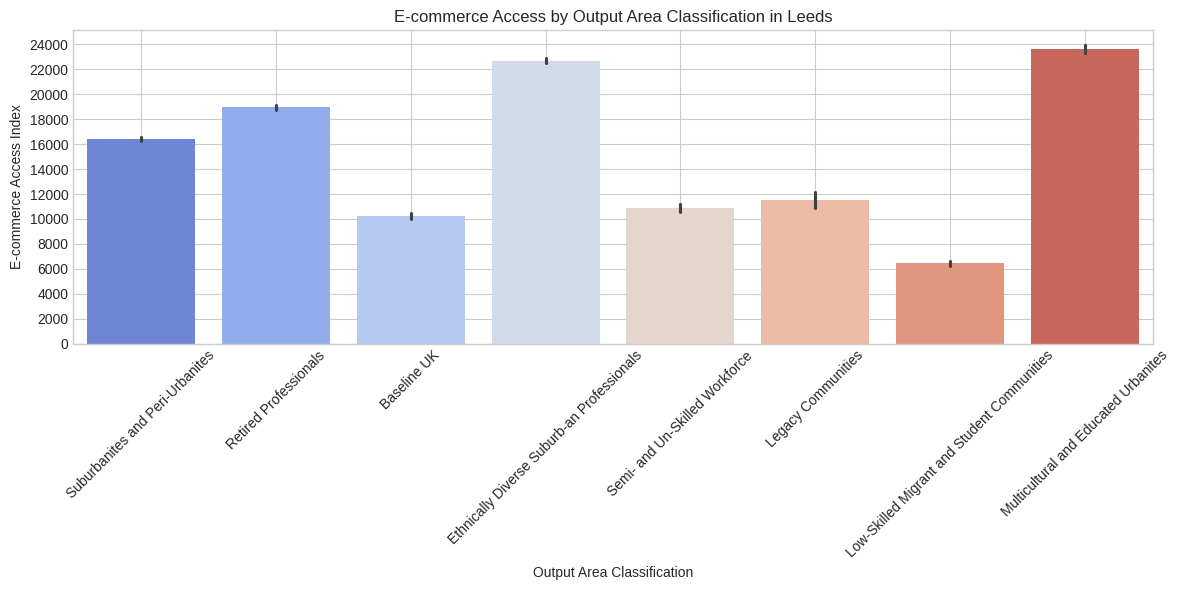

In [112]:
# Use a bar chart to display the distribution of E-commerce Access based on Output Area Classification
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Classification Name', y='domain_ecommerce_access', hue='Classification Name', data=leeds_specific,
            palette='coolwarm', legend=False)

# Set x-axis scale interval
ax.yaxis.set_major_locator(ticker.MultipleLocator(2000))  # Display a scale every 2000
plt.xticks(rotation=45)
plt.title('E-commerce Access by Output Area Classification in Leeds')
plt.xlabel('Output Area Classification')
plt.ylabel('E-commerce Access Index')
plt.grid(True)  # Display gridlines to help read
plt.tight_layout()  # Adjust Layout
plt.show()

spatial data visualisation: To gain a clearer spatial understanding of the distribution of E-commerce Access, it is proposed to visualize it spatially. Initially, examine the attribute table of the shapefile to determine if there is a common field with the leeds_specific data, and then link the two accordingly.

In [113]:
# View the shapefile information
oac_shapefile.head()


,fid,OA21CD,la23cd,sg,g,subg,geometry
0,1.0,E00000001,E09000001,3.0,3c,3c2,"POLYGON ((-0.09448 51.51976, -0.09576 51.52007..."
1,2.0,E00000003,E09000001,3.0,3c,3c2,"POLYGON ((-0.09576 51.52007, -0.09611 51.51963..."
2,3.0,E00000005,E09000001,3.0,3c,3c1,"POLYGON ((-0.09627 51.51933, -0.09573 51.51879..."
3,4.0,E00000007,E09000001,3.0,3c,3c1,"POLYGON ((-0.09601 51.51847, -0.09506 51.51824..."
4,5.0,E00000010,E09000001,3.0,3b,3b1,"POLYGON ((-0.09689 51.52267, -0.09747 51.52217..."


In [114]:
# Merge shapefile and leeds_specific datasets
merged_gdf = gpd.GeoDataFrame(pd.merge(leeds_specific, oac_shapefile, left_on='oa21cd', right_on='OA21CD', how='inner'))

merged_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30525 entries, 0 to 30524
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   lsoa21cd                 30525 non-null  object  
 1   oa21cd                   30525 non-null  object  
 2   domain_ecommerce_access  30525 non-null  float64 
 3   Classification Name      30525 non-null  object  
 4   ladnm                    30525 non-null  object  
 5   fid                      30525 non-null  float64 
 6   OA21CD                   30525 non-null  object  
 7   la23cd                   30525 non-null  object  
 8   sg                       30525 non-null  float64 
 9   g                        30525 non-null  object  
 10  subg                     30525 non-null  object  
 11  geometry                 30525 non-null  geometry
dtypes: float64(3), geometry(1), object(8)
memory usage: 2.8+ MB


After linking the attribute table, the data was spatially visualized based on the 'domain_ecommerce_access' field. To accommodate color-blind individuals and to ensure that the expressed colors correlate with the content, the coolwarm color palette was inverted, aligning the final color representation with the magnitude values shown in the legend. The data was classified into nine categories using the natural breaks method. The category names were modified according to their numerical values, and adjustments were made to the legend's position and colors to enhance readability.

<ipython-input-115-d8ab734090ad>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm', 9)


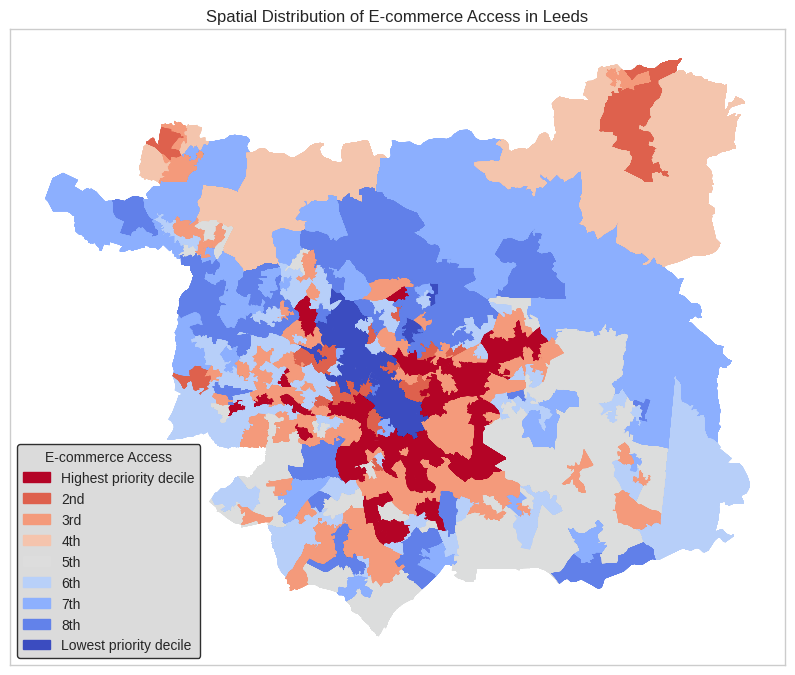

In [115]:
# Creat Shape and Axis Objects
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

merged_gdf.plot(column='domain_ecommerce_access', ax=ax, legend=True,
                cmap='coolwarm_r',  # Use the coolwarm palette and reverse color mapping
                scheme='NaturalBreaks', k=9)

# Add title
ax.set_title('Spatial Distribution of E-commerce Access in Leeds')

# Remove the display of coordinate axis
ax.set_xticks([])
ax.set_yticks([])

# Define classification names
categories = ['Highest priority decile', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', 'Lowest priority decile']

# Get color maps with 9 color levels
cmap = plt.cm.get_cmap('coolwarm', 9)

# Create patches for the legend
patches = [mpatches.Patch(color=cmap(norm), label=label) for label, norm in zip(categories, np.linspace(1, 0, 9))]

# Add the legend
leg = ax.legend(handles=patches, loc='lower left', title='E-commerce Access', facecolor='lightgray', frameon=True)

# Change the legend border color
leg.get_frame().set_edgecolor('black')

plt.show()

## References
<p><a href="https://data.cdrc.ac.uk/dataset/priority-places-food-index-version-2">[1]</a>CRDC: Priority Places for Food Index Version 2</p>
<p><a href="https://data.cdrc.ac.uk/dataset/output-area-classification-2021">[2]</a>CRDC: Output Area Classification (2021)</p>
<p><a href="https://hub.arcgis.com/datasets/41326ed502d54089acdaa4fa3488d37b/about">[3]</a>ArcGIS Hub: Postcode to OA (2021) to LSOA to MSOA to LAD with Classifications (November 2023) Best Fit Lookup in the UK</p>
<p><a href="https://www.edrawsoft.com/histogram-vs-bar-chart.html">[4]</a>Bar Chart vs Histogram</p>